from https://nbviewer.jupyter.org/url/root.cern/doc/master/notebooks/rf102_dataimport.py.nbconvert.ipynb

In [1]:
import ROOT
from array import array
from ROOT import gROOT 
import numpy as np
import os

Welcome to JupyROOT 6.18/04


## Trying Simultaneous fit
https://root.cern.ch/doc/master/rf501__simultaneouspdf_8py.html

In [2]:
# dgq = 'dataRun2'
dgq = 'gjets'
ee = 'e30_60'

In [3]:
if "data" in dgq:
    if(not os.path.exists("mypow_cxx.so")):
        ROOT.RooClassFactory.makePdf(
         "mypow", "x,p0,p1", "", "p0*TMath::Exp(p1*x)") #Declare function
    ROOT.gROOT.ProcessLineSync(".x mypow.cxx+") # Compile it for Roofit


In [4]:
binw = 0.025

if 'data' in dgq:
    rlow =  0.375 #- 1*binw 
    rhigh = 0.725 #- 1*binw
else:
    rlow = 0.375
    rhigh = 0.725-0.05
    
#0.4, 0.68 for 30-60 data and gjets
#0.35, 0.7
# rlow = 0.4
# rhigh = 0.7
helpme = 0.02

In [5]:
# inFile = ROOT.TFile("./{}Out_{}.root".format(dgq, ee), "read")
if("data" in dgq):
    inFile = ROOT.TFile("./NoTrigOutFiles/{}Out_{}.root".format(dgq, ee), "read")
elif(dgq=="gjets"):
    #inFile = ROOT.TFile("./GJetsFiles/gjetsOut_e30_60_2016.root","read")
    inFile = ROOT.TFile("./GJetsFiles/gjetsOut_m_Run2.root","read")

    
# hist_p = inFile.Get("mass_pp")
# hist_f = inFile.Get("mass_ff")
if("data" in dgq):
    hist_p = inFile.Get("mass_pp")
    hist_f = inFile.Get("mass_ff")
else:
    hist_p = inFile.Get("mass")
    hist_f = inFile.Get("fail")

In [6]:
# c1 = ROOT.TCanvas("c", "c", 800, 800)
# c1.cd()
# hist_f.Draw("hist")
# gROOT.GetListOfCanvases().Draw()

In [7]:
# passhist = ROOT.TH1F("pass", "diphoton mass ; mass (GeV) ; ", hist_p.GetNbinsX(), hist_p.GetBinCenter(1), hist_p.GetBinCenter(hist_p.GetNbinsX() + 1) )
# failhist = ROOT.TH1F("fail", "diphoton mass ; mass (GeV) ; ", hist_f.GetNbinsX(), hist_f.GetBinCenter(1), hist_f.GetBinCenter(hist_f.GetNbinsX() + 1) )

passhist = ROOT.TH1F("pass", "diphoton mass ; mass (GeV) ; ", hist_p.GetNbinsX(), hist_p.GetBinLowEdge(1), hist_p.GetBinLowEdge(hist_p.GetNbinsX() + 1) )
failhist = ROOT.TH1F("fail", "diphoton mass ; mass (GeV) ; ", hist_f.GetNbinsX(), hist_f.GetBinLowEdge(1), hist_f.GetBinLowEdge(hist_f.GetNbinsX() + 1) )


#Pass
for i in range(1, hist_p.GetNbinsX()+1):
    if(hist_p.GetBinContent(i) < 0): continue
    if( hist_p.GetBinCenter(i) >= rlow-helpme and hist_p.GetBinCenter(i) < rhigh):
        passhist.SetBinContent(i, hist_p.GetBinContent(i))

#Fail
for i in range(1, hist_f.GetNbinsX()+1):
    if(hist_f.GetBinContent(i) < 0): continue
    if( hist_f.GetBinCenter(i) >= rlow-helpme and hist_f.GetBinCenter(i) < rhigh):
        failhist.SetBinContent(i, hist_f.GetBinContent(i))

        
# passhist.GetXaxis().SetRangeUser(rlow, rhigh)
# failhist.GetXaxis().SetRangeUser(rlow, rhigh)

Warning in <TFile::Append>: Replacing existing TH1: fail (Potential memory leak).


In [8]:
# c1 = ROOT.TCanvas("c", "c", 400, 400)
# c1.cd()
# # failhist.Draw("SAME")
# passhist.Draw("SAME")
# # gROOT.GetListOfCanvases().Draw()

In [9]:
passhist.Integral()

3129.56929397583

In [10]:
x = ROOT.RooRealVar("x", "x", rlow+0.02, rhigh)

In [11]:
data_pass = ROOT.RooDataHist("dh","dh",ROOT.RooArgList(x), passhist)
data_fail = ROOT.RooDataHist("df","df",ROOT.RooArgList(x), failhist)

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(dh): fit range of variable x expanded to nearest bin boundaries: [0.395,0.675] --> [0.375,0.675]


In [12]:
#Passing PDF

ss = 0.0401
se = 2.0e-05
sw = 10000

# #Signal PDF
# # mean_p = ROOT.RooRealVar("mean_p", "mean_p", 0.548, 0.5, 0.6)
# mean_p = ROOT.RooRealVar("mean_p", "mean_p", 0.55, 0.53, 0.6)
# # sigma_p = ROOT.RooRealVar("sigma_p", "sigma_p", 4.0e-02, 4.0e-02 - 100*2.0e-04, 4.0e-02 + 100*2.0e-04)
# sigma_p = ROOT.RooRealVar("sigma_p", "sigma_p", ss, ss-sw*se, ss+sw*se)

# gx_p = ROOT.RooGaussian("gauss_pass", "gauss_pass", x, mean_p, sigma_p)

#DoubleSidedCB
mean_p = ROOT.RooRealVar("mean_p", "mean of gaussian", 0.548, 0.53, 0.57)
sigma_p = ROOT.RooRealVar("sigma_p", "width of gaussian", 4.09936e-02, 0.03, 0.05)
alpha1 = ROOT.RooRealVar("alpha1", "alpha1 of gaussian", 8.88792e+00, 0.0001, 11)
# alpha2 = ROOT.RooRealVar("alpha2", "alpha2 of gaussian", 4.82348e+00, 0.0001, 11)
alpha2 = ROOT.RooRealVar("alpha2", "alpha2 of gaussian", 4.86301e+00,4.6e+00, 5.0e+00)
n1 = ROOT.RooRealVar("n1", "n1 of gaussian", 4.15948e+00, 0.0001, 10)
# n2 = ROOT.RooRealVar("n2", "n2 of gaussian", 6.62385e-01, 0.000001, 10)
n2 = ROOT.RooRealVar("n2", "n2 of gaussian", 6.62385e-01, 6.62385e-01, 6.62385e-01)
gx_p = ROOT.RooDoubleCB("dscb","dscb",x,mean_p,sigma_p,alpha1,n1,alpha2,n2)

alpha2.setVal(4.82348e+00)
n2.setVal(6.62385e-01)


#Background PDF
#Power 
if 'data' in dgq:
    a0_p = ROOT.RooRealVar("a0_p", "a0_p", 10, -100, 100)
    a1_p = ROOT.RooRealVar("a1_p", "a1_p", 1, -10, 10)

    px_p = ROOT.mypow("px_p", "px_p", x, a0_p, a1_p)
    
else:

    # Argus
    m_p = ROOT.RooRealVar("m_p", "m_p", 10, 0, 100)
    m0_p = ROOT.RooRealVar("m0_p", "m0_p", -1, -100, 10)
    c_p = ROOT.RooRealVar("c_p", "c_p", 1, -100, 100)
    px_p = ROOT.RooArgusBG("px_p", "px_p", x, m_p, m0_p, c_p)


# Construct composite pdf
f_p = ROOT.RooRealVar("f_p", "f_p", 0.2, 0.0, 1.0)
model_p = ROOT.RooAddPdf("model_p", "model_p", ROOT.RooArgList(gx_p, px_p), ROOT.RooArgList(f_p))

# model_p.fitTo(data_pass)

a_p = ROOT.RooRealVar("a_p","a_p", passhist.Integral())
p_ext = ROOT.RooExtendPdf("modelp","modelp",model_p,a_p)

# p_ext.fitTo(data_pass)

In [13]:
p_ext

<ROOT.RooExtendPdf object ("modelp") at 0x7650af0>

In [14]:
#Background
# #Power 
#Power 
if 'data' in dgq:
    a0_f = ROOT.RooRealVar("a0_f", "a0_f", 10, -100, 100)
    a1_f = ROOT.RooRealVar("a1_f", "a1_f", 1, -10, 10)

    px_f = ROOT.mypow("px_f", "px_f", x, a0_f, a1_f)
    
else:
   
    # Argus
    m_f = ROOT.RooRealVar("m_f", "m_f", 10, 0, 100)
    m0_f = ROOT.RooRealVar("m0_f", "m0_f", -1, -100, 100)
    c_f = ROOT.RooRealVar("c_f", "c_f", 1, -100, 100)
    px_f = ROOT.RooArgusBG("px_f", "px_f", x, m_f, m0_f, c_f)


# #Polynomial
# p = ROOT.RooRealVar("coeff","coeff",0,-10,10)
# px_f = ROOT.RooPolynomial("poly","poly",x,p,lowestorder=3)

# Construct composite pdf
f_f = ROOT.RooRealVar("f_f", "f_f", 0.2, 0.0, 1.0)
model_f = ROOT.RooAddPdf("model_f", "model_f", ROOT.RooArgList(gx_p, px_f), ROOT.RooArgList(f_f))

a_f = ROOT.RooRealVar("a_f","a_f", failhist.Integral())
f_ext = ROOT.RooExtendPdf("modelf","modelf",model_f,a_f)



In [15]:
# Define category to distinguish physics and control samples events
sample = ROOT.RooCategory("sample", "sample")
sample.defineType("pass")
sample.defineType("fail")

False

In [16]:
# Construct combined dataset in (x,sample)
combData = ROOT.RooDataHist(
    "combData",
    "combined data",
    ROOT.RooArgList(x),
    ROOT.RooFit.Index(sample),
    ROOT.RooFit.Import("pass", passhist),
    ROOT.RooFit.Import("fail", failhist),
)
 

In [17]:
# Construct a simultaneous pdf using category sample as index
simPdf = ROOT.RooSimultaneous("simPdf", "simultaneous pdf", sample)

# Associate model with the physics state and model_ctl with the control
# state
# simPdf.addPdf(model_p, "pass")
# simPdf.addPdf(model_f, "fail")
simPdf.addPdf(p_ext, "pass")
simPdf.addPdf(f_ext, "fail")

False

In [18]:
abc = simPdf.fitTo(combData, ROOT.RooFit.Save())


[#0] WARNING:InputArguments -- RooAbsPdf::fitTo(simPdf) WARNING: a likelihood fit is requested of what appears to be weighted data.
       While the estimated values of the parameters will always be calculated taking the weights into account,
       there are multiple ways to estimate the errors of the parameters. You are advised to make an'n       explicit choice for the error calculation:
           - Either provide SumW2Error(true), to calculate a sum-of-weights-corrected HESSE error matrix
             (error will be proportional to the number of events in MC).
           - Or provide SumW2Error(false), to return errors from original HESSE error matrix
             (which will be proportional to the sum of the weights, i.e., a dataset with <sum of weights> events).
       If you want the errors to reflect the information contained in the provided simulation, choose true.
       If you want the errors to reflect the precision you would be able to obtain with an unweighted dataset
  

In [19]:
# simPdf.minNll()

In [20]:
if(dgq=='qcd'):color = 46
if(dgq=='gjets'): color= 30
elif(dgq=='mc'):color = 6
else: color = 4

In [21]:
frame1 = x.frame(ROOT.RooFit.Title("Pass sample, {}".format(dgq)))

In [22]:
combData.plotOn(frame1, ROOT.RooFit.Cut("sample==sample::pass"),  ROOT.RooFit.Name("combData"), ROOT.RooFit.DataError(ROOT.RooAbsData.SumW2))

<ROOT.RooPlot object ("frame_x_77dd5b0") at 0x77dd5b0>

[#1] INFO:Plotting -- RooTreeData::plotOn: plotting 3094.74 events out of 4192.25 total events


In [23]:
sampleSet = ROOT.RooArgSet(sample)

simPdf.plotOn(frame1, ROOT.RooFit.Slice(sample, "pass"), 
              ROOT.RooFit.ProjWData(sampleSet, combData),
              ROOT.RooFit.LineColor(color),
              ROOT.RooFit.Name("simPdf")
             )


simPdf.plotOn(frame1, 
              ROOT.RooFit.Slice(sample, "pass"), 
              ROOT.RooFit.Components("px_p"), 
              ROOT.RooFit.ProjWData(sampleSet, combData), 
              ROOT.RooFit.LineStyle(ROOT.kDashed),
              ROOT.RooFit.LineColor(color)
             )



<ROOT.RooPlot object ("frame_x_77dd5b0") at 0x77dd5b0>

[#1] INFO:Plotting -- RooSimultaneous::plotOn(simPdf) plot on x represents a slice in the index category (sample)
[#1] INFO:Plotting -- RooAbsReal::plotOn(modelp) slice variable sample was not projected anyway
[#1] INFO:NumericIntegration -- RooRealIntegral::init(px_p_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Plotting -- RooSimultaneous::plotOn(simPdf) plot on x represents a slice in the index category (sample)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(modelp) directly selected PDF components: (px_p)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(modelp) indirectly selected PDF components: (model_p)
[#1] INFO:Plotting -- RooAbsReal::plotOn(modelp) slice variable sample was not projected anyway
[#1] INFO:NumericIntegration -- RooRealIntegral::init(px_p_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)


In [24]:
frame2 = x.frame(ROOT.RooFit.Title("Fail sample, {}".format(dgq)))
combData.plotOn(frame2, ROOT.RooFit.Cut("sample==sample::fail"),  ROOT.RooFit.Name("combData"))
simPdf.plotOn(frame2, ROOT.RooFit.Slice(sample, "fail"), 
              ROOT.RooFit.ProjWData(sampleSet, combData),
#               ROOT.RooFit.LineStyle(ROOT.kDashed),
              ROOT.RooFit.LineColor(color),
              ROOT.RooFit.Name("simPdf")
             )

simPdf.plotOn(frame2, 
              ROOT.RooFit.Slice(sample, "fail"), 
              ROOT.RooFit.Components("px_f"), 
              ROOT.RooFit.ProjWData(sampleSet, combData), 
              ROOT.RooFit.LineStyle(ROOT.kDashed),
              ROOT.RooFit.LineColor(color)
             )

# c = ROOT.TCanvas("rf501_simultaneouspdf", "rf501_simultaneouspdf", 1200, 600)
# c.Divide(2,1)
# c.cd(1)
# ROOT.gPad.SetLeftMargin(0.15)
# ROOT.gStyle.SetOptFit(1111)
# frame1.GetYaxis().SetTitleOffset(1.4)
# frame1.SetLineColor(color)
# frame1.GetYaxis().SetRangeUser(0.75*passhist.GetMinimum(), 1.15 * passhist.GetMaximum())
# frame1.Draw()
# c.Update()

# c.cd(2)
# ROOT.gPad.SetLeftMargin(0.15)
# frame2.GetYaxis().SetTitleOffset(1.4)
# frame1.SetLineColor(color)
# frame2.GetYaxis().SetRangeUser(0.75*failhist.GetMinimum(), 1.15 * failhist.GetMaximum())
# frame2.Draw()

# c.SaveAs("simultaneouspdf_{}.png".format(dgq))

<ROOT.RooPlot object ("frame_x_7b1fa20") at 0x7b1fa20>

[#1] INFO:InputArguments -- RooAbsData::plotOn(combData) INFO: dataset has non-integer weights, auto-selecting SumW2 errors instead of Poisson errors
[#1] INFO:Plotting -- RooTreeData::plotOn: plotting 1097.51 events out of 4192.25 total events
[#1] INFO:Plotting -- RooSimultaneous::plotOn(simPdf) plot on x represents a slice in the index category (sample)
[#1] INFO:Plotting -- RooAbsReal::plotOn(modelf) slice variable sample was not projected anyway
[#1] INFO:NumericIntegration -- RooRealIntegral::init(px_f_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Plotting -- RooSimultaneous::plotOn(simPdf) plot on x represents a slice in the index category (sample)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(modelf) directly selected PDF components: (px_f)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(modelf) indirectly selected PDF components: (model_f)
[#1] INFO:Plotting -- RooAbsReal::plotOn(modelf) slice variable sample was not projected anyway
[#1] INFO:NumericIntegra

In [25]:
eff = ROOT.RooFormulaVar("eff", "(a_p * f_p) / (a_f * f_f + a_p * f_p) ", ROOT.RooArgList(a_p, f_p, a_f, f_f))


In [26]:
p = f_p.getVal()
f = f_f.getVal()

dp = f_p.getError()
df = f_f.getError()

a = f+p
da = np.sqrt(df*df + dp*dp)

In [27]:
deffoeff = np.sqrt( (dp/p)**2 + (da / a)**2 )
deff = deffoeff * eff.getVal()

In [28]:
print("Efficiency is: {:.4f} +/- {:.4f} %".format(eff.getVal()*100, deff*100))

Efficiency is: 85.2984 +/- 3.9929 %


In [29]:
dmu = 54.9157 #Data efficiency and uncertainty
dmu_err = 0.6363

gmu = 53.1811 #GJets efficiency and uncertainty
gmu_err = 9.4408

# y = 55.0452 #GJets efficiency and uncertainty with weights
# dy = 10.4371

z = dmu/gmu
dz = z * np.sqrt( (dmu_err/gmu)**2 + (gmu_err/gmu)**2 )

print("Scale Factor is {:.4f} +\- {:.4f}".format(z, dz))

Scale Factor is 1.0326 +\- 0.1837


In [30]:
np.sqrt((19. / 54.)**2)

0.35185185185185186

In [31]:
f_p.getVal()

0.6522297491821115

In [32]:
print("Pass Values:")
print("Norm: {}".format(a_p.getVal()))
print("\nGaussian: ")
print("mu = {:.4f} +/- {:.4f}".format(mean_p.getVal(), mean_p.getError()))
print("sigma = {:.4f} +/- {:.4f}".format(sigma_p.getVal(), sigma_p.getError()))


print("\nBackground: ")

if 'data' in dgq:
    print("p0 = {:.2f} +/- {:.2f}".format(a0_p.getVal(), a0_p.getError()))
    print("p1 = {:.2f} +/- {:.2f}".format(a1_p.getVal(), a1_p.getError()))
   
else:
    # Argus
    print("m = {:.2f} +/- {:.2f}".format(m_p.getVal(), m_p.getError()))
    print("m0 = {:.2f} +/- {:.2f}".format(m0_p.getVal(), m0_p.getError()))
    print("c = {:.2f} +/- {:.2f}".format(c_p.getVal(), c_p.getError()))
    


Pass Values:
Norm: 3129.56929398

Gaussian: 
mu = 0.5467 +/- 0.0013
sigma = 0.0443 +/- 0.0011

Background: 
m = 16.74 +/- 4.98
m0 = -81.68 +/- 78.97
c = -98.58 +/- 191.54


In [33]:
print(ss-sw*se)
print(ss+sw*se)

-0.1599
0.2401


In [34]:
print("Fail Values:")
print("Norm: {}".format(a_f.getVal()))
print("\nGaussian")
print("mu = {:.4f} +/- {:.4f}".format(mean_p.getVal(), mean_p.getError()))
print("sigma = {:.4f} +/- {:.4f}".format(sigma_p.getVal(), sigma_p.getError()))

print("\nBackground: ")

if 'data' in dgq:
    print("p0 = {:.2f} +/- {:.2f}".format(a0_f.getVal(), a0_f.getError()))
    print("p1 = {:.3f} +/- {:.3f}".format(a1_f.getVal(), a1_f.getError()))
   
else:
    # Argus
    print("m = {:.2f} +/- {:.2f}".format(m_f.getVal(), m_f.getError()))
    print("m0 = {:.2f} +/- {:.2f}".format(m0_f.getVal(), m0_f.getError()))
    print("c = {:.2f} +/- {:.2f}".format(c_f.getVal(), c_f.getError()))



Fail Values:
Norm: 1137.53237915

Gaussian
mu = 0.5467 +/- 0.0013
sigma = 0.0443 +/- 0.0011

Background: 
m = 10.77 +/- 1.32
m0 = -99.70 +/- 197.95
c = -99.61 +/- 197.30


In [35]:
# pl = p_ext.getParameters(data_pass).contentsString().split(",")
# fl = f_ext.getParameters(data_pass).contentsString().split(",")
# cc = 0
# for ff in fl: 
#     if(ff not in pl): cc += 1
# nparams = len(pl) + cc

if 'data' in dgq:
    nparams = 8
else: 
    nparams = 10
    
# chi2 = frame1.chiSquare("simPdf", "combData" )
# print("Chi2 / ndof is {}".format(chi2))
# chi2 = frame2.chiSquare("simPdf", "combData")
# print("Chi2 / ndof is {}".format(chi2))
    
chi2 = frame1.chiSquare("simPdf", "combData", nparams)
print("Chi2 / ndof is {}".format(chi2))
chi2 = frame2.chiSquare("simPdf", "combData", nparams)
print("Chi2 / ndof is {}".format(chi2))

Chi2 / ndof is 3.15230051859
Chi2 / ndof is 10.4924886689


In [36]:

hpull = frame1.pullHist("combData", "simPdf")
frame1P = x.frame(ROOT.RooFit.Title(""))
frame1P.addPlotable(hpull, "P")

hpull2 = frame2.pullHist("combData", "simPdf")
frame2P = x.frame(ROOT.RooFit.Title(""))
frame2P.addPlotable(hpull2, "P")

# cA = ROOT.TCanvas("simPull", "simPull", 1200, 600)
cA = ROOT.TCanvas("simPull", "simPull", 600, 600)
# cA.Divide(2,1)

# cA.cd(1)

# p12 = ROOT.TPad("pad1", "tall",0,0.165,1,1)
# p22 = ROOT.TPad("pad2", "short",0,0.0,1.0,0.23)
# p22.SetBottomMargin(0.35)
# p12.Draw()
# p22.Draw()

# p12.cd()
# ROOT.gPad.SetLeftMargin(0.15)
# ROOT.gStyle.SetOptFit(1111)
# if("data" in dgq):
#     frame1.SetTitle("Pass Sample, Run 2 Data")
# else:
#     frame1.SetTitle("Pass Sample, Run 2 GJets")
# frame1.GetYaxis().SetTitleOffset(1.4)
# frame1.SetLineColor(color)
# passhist.GetXaxis().SetRangeUser(rlow, rhigh)
# frame1.GetYaxis().SetRangeUser(0.75*passhist.GetMinimum(), 1.15 * passhist.GetMaximum())
# frame1.GetXaxis().SetLabelOffset(999)
# frame1.GetXaxis().SetLabelSize(0)
# frame1.Draw()

# p22.cd()
# ROOT.gPad.SetLeftMargin(0.15)
# frame1P.SetTitle(";Mass(GeV);#frac{Data - Fit}{Uncertainty}")
# frame1P.GetYaxis().SetLabelSize(0.11)
# frame1P.GetXaxis().SetLabelSize(0.15)
# frame1P.GetXaxis().SetTitleSize(0.15)
# frame1P.GetYaxis().SetTitleOffset(0.3)
# frame1P.GetYaxis().SetTitleSize(0.125)
# frame1P.Draw()

# L1 = ROOT.TLine(rlow-0.005, 0, rhigh+0.005, 0)
# L1.SetLineColor(12)
# L1.Draw("same")

##############################################################



In [37]:
cA.cd(2)

p12 = ROOT.TPad("pad1", "tall",0,0.165,1,1)
p22 = ROOT.TPad("pad2", "short",0,0.0,1.0,0.23)
p22.SetBottomMargin(0.35)
p12.Draw()
p22.Draw()

p12.cd()
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gStyle.SetOptFit(1111)
frame2.GetYaxis().SetTitleOffset(1.4)
frame2.SetLineColor(color)
failhist.GetXaxis().SetRangeUser(rlow, rhigh)
frame2.GetYaxis().SetRangeUser(0.75*failhist.GetMinimum(), 1.15 * failhist.GetMaximum())
frame2.GetXaxis().SetLabelOffset(999)
frame2.GetXaxis().SetLabelSize(0)
frame2.Draw()

p22.cd()
ROOT.gPad.SetLeftMargin(0.15)
frame2P.SetTitle(";Mass(GeV);Data - Fit")
frame2P.GetYaxis().SetLabelSize(0.11)
frame2P.GetXaxis().SetLabelSize(0.15)
frame2P.GetXaxis().SetTitleSize(0.15)
frame2P.GetYaxis().SetTitleOffset(0.3)
frame2P.GetYaxis().SetTitleSize(0.15)
frame2P.Draw()

# L2 = ROOT.TLine(rlow-0.005, 0, rhigh+0.005, 0)
# L2.SetLineColor(12)
# L2.Draw("same")

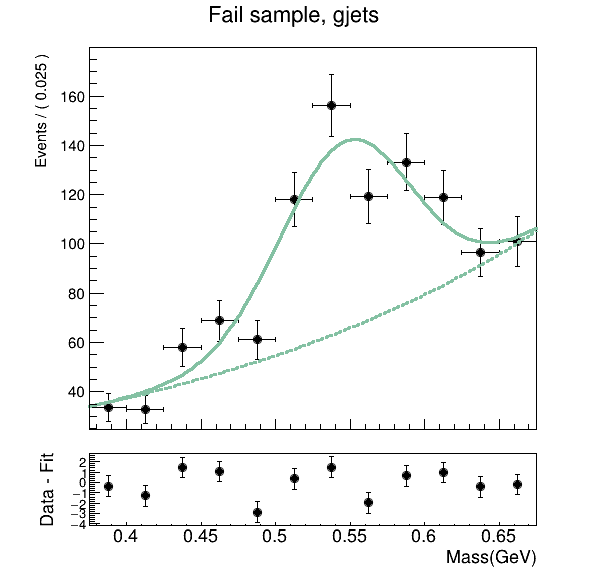

In [38]:
gROOT.GetListOfCanvases().Draw()

In [39]:
print("Eta Pass Rate is: {:.4f} +/- {:.4f} %".format(eff.getVal()*100, deff*100))
print("mu = {:.4f} +/- {:.4f}".format(mean_p.getVal(), mean_p.getError()))

Eta Pass Rate is: 85.2984 +/- 3.9929 %
mu = 0.5467 +/- 0.0013


In [40]:
54.35/53.10

1.0235404896421845

In [41]:
np.sqrt( (0.43/54.35)**2 + (8.8/53.10)**2  )

0.16591379076590876